## Capstone Project Objective
#### Transform the data into customer centric dataset to enable customer segmentation using K-means clustering algorithms. the distinct customer profiles then can be used for targetted with efficiant marketing strategies.

In [67]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

## Load the dataset

In [68]:
df = pd.read_csv('./data/data.csv', encoding='ISO-8859-1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [69]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Summary Statistics of Numerical Variables

In [70]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### Summary Statistics of non-numeric variables

In [71]:
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


# **Data Cleaning and Transformations**
- Handle missing values
- Handle Duplicates
- Handle Cancelled Transactions
- Remove Data Anolamies 

In [72]:
missingData = df.isnull().sum()
missingDataPercentage = (missingData[missingData > 0] / df.shape[0]) * 100
print(missingDataPercentage)
# Drop transaction with null Customer ID and Description
df.dropna(subset=['CustomerID', 'Description'], inplace=True)
# Drop Duplicates
print(f'Dataset contains {df.duplicated().sum()} duplicate rows')
df.drop_duplicates(inplace=True)
# Remove Cancelled Transaction
df.drop(df[df['InvoiceNo'].str.startswith('C')].index, inplace=True)
# Remove StockCode data anomalies
df.drop(df[pd.to_numeric(df['StockCode'], errors='coerce').isna()].index, inplace=True)
# Drop rows where unit price is zero
df.drop(df[df['UnitPrice'] <= 0].index, inplace=True)
# Drop data anomalies, Some product description suggests that they may not be a real product instead a suporting product SKU
df.drop(df[df['Description'].isin(['Next Day Carriage', 'High Resolution Image'])].index, inplace=True)



Description     0.268311
CustomerID     24.926694
dtype: float64
Dataset contains 5225 duplicate rows


#### Country distributions

In [73]:
df['Country'].value_counts(normalize=True).head()

Country
United Kingdom    0.889870
Germany           0.022588
France            0.021332
EIRE              0.018286
Netherlands       0.006201
Name: proportion, dtype: float64

#### Save Cleaned data

In [74]:
df.to_csv('./data/cleaned_data.csv', index=False)

# **Feature Engineering**

### RFM Features
Is a methos for analysing customer value and segmenting the customer base.

- **Recency(R)**: How recently customer has made the purchase?
- **Frequency(F)**: How ofter customer makes a purchase within a certain period?
- **Monetory(M)**: Total amount customer has spent over certain period.

In [75]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDay'] = df['InvoiceDate'].dt.date

customerData = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

#Most recent Date in entire dataset
mostRecentDate = pd.to_datetime(df['InvoiceDay'].max())

#Number of days su=ince last purchase
customerData['DaysSinceLastPurchase'] = (mostRecentDate - pd.to_datetime(customerData['InvoiceDay'])).dt.days
customerData.drop(columns=['InvoiceDay'], inplace=True)
customerData.head()

,CustomerID,DaysSinceLastPurchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


#### Add feature columns for TotalTransactions, TotalProductsPurchased, TotalSpend, AverageTransactionValue, UniqueProductsPurchased and Country by a customer

In [76]:
df['TotalSpend'] = df['UnitPrice'] * df['Quantity']
customerData = customerData.merge(df.groupby('CustomerID')['InvoiceNo'].nunique(), on='CustomerID', how='left')
customerData = customerData.merge(df.groupby('CustomerID')['Quantity'].sum(), on='CustomerID', how='left')
customerData = customerData.merge(df.groupby('CustomerID')['TotalSpend'].sum(), on='CustomerID', how='left')
customerData = customerData.merge(df.groupby('CustomerID')['StockCode'].nunique(), on='CustomerID', how='left')
customerData = customerData.merge(df.groupby('CustomerID')['Country'].unique(), on='CustomerID', how='left')
customerData.rename(columns={'InvoiceNo':'TotalTransactions', 'Quantity':'TotalProductsPurchased', 'StockCode':'UniqueProductsPurchased', 'Country': 'Is_UK'}, inplace=True)
customerData['AverageTransactionValue'] = customerData['TotalSpend'] / customerData['TotalTransactions']
# We know large number of customers are from UK, the columns vaues can be set to 1 or 0 based on if the customer country is UK or not.
customerData['Is_UK'] = customerData['Is_UK'].apply(lambda x: 1 if x.any() == 'United Kingdom' else 0)
customerData.head()

,CustomerID,DaysSinceLastPurchase,TotalTransactions,TotalProductsPurchased,TotalSpend,UniqueProductsPurchased,Is_UK,AverageTransactionValue
0,12346.0,325,1,74215,77183.60,1,1,77183.600000
1,12347.0,2,7,2137,3653.45,90,0,521.921429
2,12348.0,75,4,2332,1437.24,21,0,359.310000
3,12349.0,18,1,611,1372.42,68,0,1372.420000
4,12350.0,310,1,168,258.00,13,0,258.000000


#### Outlier Detection and Treatment

The isolation forest algorithm isolates obserations by randomly selecting the feature in multidimensional database and thenrandomly selecting the split value betwen max and in values of the selcted feature.

In [77]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.05, random_state=0)
customerData['Outlier'] = model.fit_predict(customerData.iloc[:,1:].to_numpy())
customerData['Outlier'] = customerData['Outlier'].apply(lambda x:1 if x == -1 else 0)
customerData.head()

,CustomerID,DaysSinceLastPurchase,TotalTransactions,TotalProductsPurchased,TotalSpend,UniqueProductsPurchased,Is_UK,AverageTransactionValue,Outlier
0,12346.0,325,1,74215,77183.60,1,1,77183.600000,1
1,12347.0,2,7,2137,3653.45,90,0,521.921429,0
2,12348.0,75,4,2332,1437.24,21,0,359.310000,0
3,12349.0,18,1,611,1372.42,68,0,1372.420000,1
4,12350.0,310,1,168,258.00,13,0,258.000000,0


In [78]:
# Save cleaned customer data, after removing outliers
clean_customer_data = customerData[customerData['Outlier'] == 0].drop(columns='Outlier')
clean_customer_data.to_csv('./data/cleaned_customer_data.csv', index=False)

#### Check the presence of multicollinearity in the customer dataset
Features which are found to be correlated can be transformed to new uncorrelated variables but still preserving original data varience. This ill enhance cluster quality and make process more computationally efficiant.

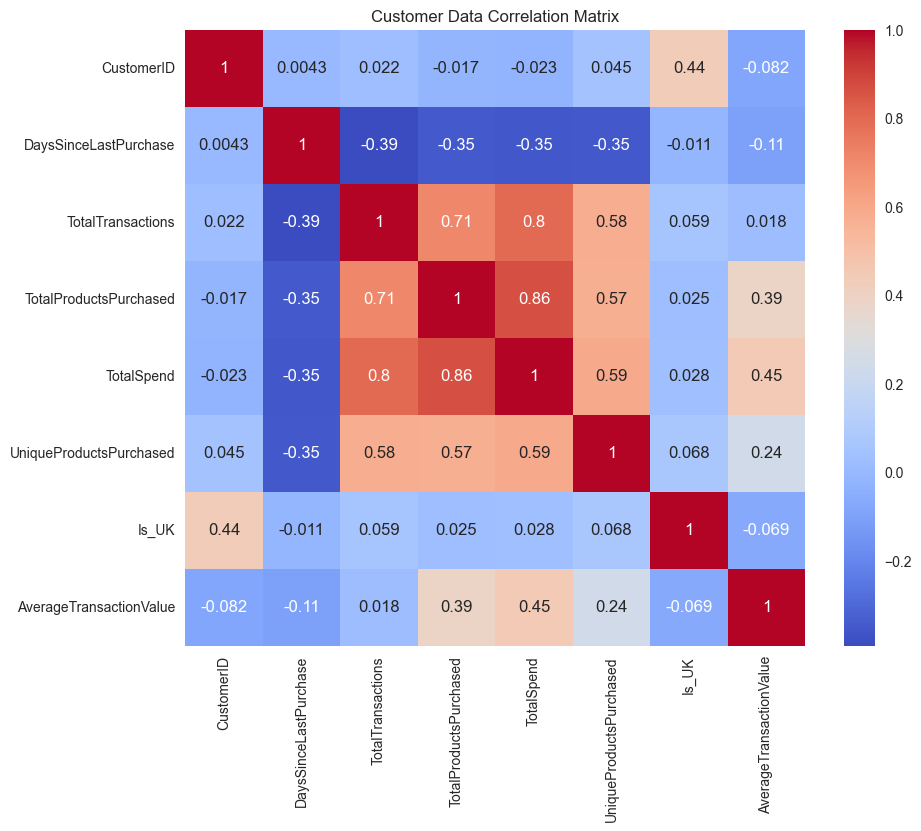

In [79]:
import seaborn as sns
corr = clean_customer_data.corr()

plt.figure(figsize=(10,8))
plt.title('Customer Data Correlation Matrix')
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()


#### Analysis above shows that there is a string correlation between TotalSpend and TotalProductsPurchased and a TotalSpend with TotalTransactions

### Feature Scaling
Distance based algorithms requires features to be correctly scaled.

In [80]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_customer_data = clean_customer_data.copy()
scaledColumns = ['DaysSinceLastPurchase', 'TotalTransactions', 'TotalProductsPurchased', 'TotalSpend', 'UniqueProductsPurchased', 'AverageTransactionValue']
scaled_customer_data[scaledColumns] = scaler.fit_transform(scaled_customer_data[scaledColumns])
scaled_customer_data.head()

,CustomerID,DaysSinceLastPurchase,TotalTransactions,TotalProductsPurchased,TotalSpend,UniqueProductsPurchased,Is_UK,AverageTransactionValue
1,12347.0,-0.918543,1.031527,1.891846,2.053804,0.738719,0,1.025664
2,12348.0,-0.189831,0.166126,2.135449,0.314418,-0.529321,0,0.278143
4,12350.0,2.156026,-0.699276,-0.567927,-0.611105,-0.676340,0,-0.187576
5,12352.0,-0.579143,1.031527,-0.133188,0.264188,0.113888,0,-0.471774
6,12353.0,1.097895,-0.699276,-0.752815,-0.743744,-0.841737,0,-0.964465


# **Dimensionality Reduction - PCA, Principal Component Analysis**
Add more details .... here Pramod.

[3.43267181 1.02784187 0.75855192 0.50634313 0.20216961 0.07589717
 0.07184469] [0.56501908 0.73420224 0.85906017 0.94240444 0.97568163 0.98817434
 1.        ]


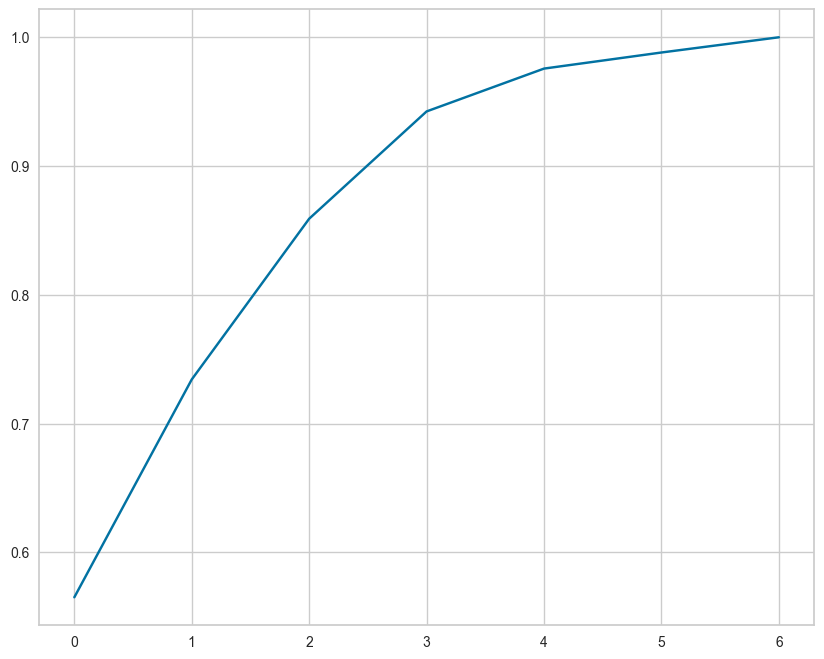

In [81]:
from sklearn.decomposition import PCA
scaled_customer_data.set_index('CustomerID', inplace=True)
pca = PCA().fit(scaled_customer_data)
varianceRatio = pca.explained_variance_
cumulativeVarience = np.cumsum(pca.explained_variance_ratio_)
print(varianceRatio, cumulativeVarience)

#Plot PCA
plt.figure(figsize=(10, 8))
sns.lineplot(x=range(0, len(cumulativeVarience)), y=cumulativeVarience, markers='o')
plt.show()




#### First 3 PCA covers around 86% variance

In [82]:
pcaApplied = PCA(n_components=3)

pca_customer_data = pd.DataFrame(pcaApplied.fit_transform(scaled_customer_data))
pca_customer_data.head()

,0,1,2
0,3.220519,0.562055,-0.092476
1,1.167708,0.425267,0.207625
2,-1.843722,0.769294,1.527525
3,0.638027,-0.940264,-0.086362
4,-1.942366,-0.262917,0.735753


#### PCA Components
Shows the PCA spead across the features

In [83]:
pd.DataFrame(pcaApplied.components_.T, index=scaled_customer_data.columns)

,0,1,2
DaysSinceLastPurchase,-0.285572,0.331952,0.887063
TotalTransactions,0.454594,-0.361984,0.278276
TotalProductsPurchased,0.485947,0.096967,0.174915
TotalSpend,0.506358,0.109462,0.181506
UniqueProductsPurchased,0.409723,-0.089123,0.025233
Is_UK,0.005542,-0.024242,0.014327
AverageTransactionValue,0.226598,0.853733,-0.267020


# **K-Means Clustering**

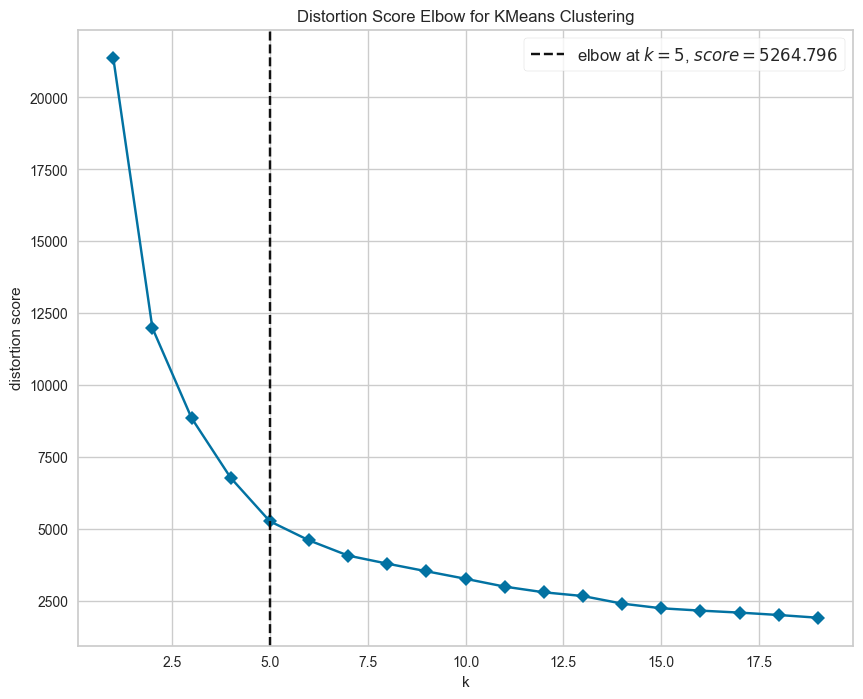

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [84]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans(random_state=0)
fig, ax = plt.subplots(figsize=(10,8))
# Find optimum value for the ny=umber of clusters
visualiser = KElbowVisualizer(kmeans, k=(1,20), timings=False, ax = ax)
visualiser.fit(pca_customer_data)
visualiser.show()

#### The best cluster value is found to be 5
Scikit Learn library, by default use Euclidian distance as a measure to evaluate the nearness of the data points

$$
d(\mathbf{p}, \mathbf{q}) = \sqrt{\sum_{i=1}^{n} {q_i - p_i}^2}
$$

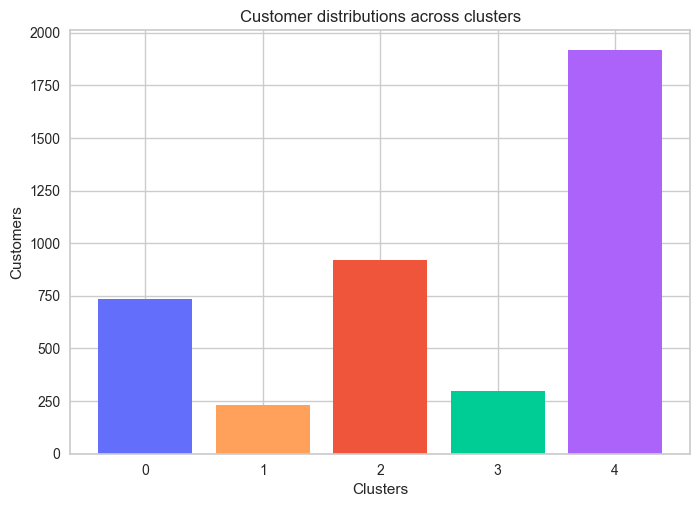

In [85]:
from collections import Counter
model = KMeans(n_clusters=5, random_state=0)
model.fit(pca_customer_data)
pca_customer_data.loc[:,"cluster"] = model.labels_
clean_customer_data.loc[:,"cluster"] = model.labels_
frequencies = Counter(model.labels_)
keys = frequencies.keys();
values = frequencies.values();
plt.xlabel("Clusters")
plt.ylabel("Customers")
clusterColours = {0:'#636EFA' , 1:'#FFA15A' , 2:'#EF553B' , 3:'#00CC96' , 4:'#AB63FA' }
plt.bar(keys, values,color=[clusterColours[cluster] for cluster in keys])
plt.title('Customer distributions across clusters')
plt.show()
pca_customer_data['cluster'] = pca_customer_data['cluster'].astype('str')


#### Visualise these 5 clusters on PCA scatter plot

In [86]:
import plotly.express as px
fig = px.scatter_3d(pca_customer_data, x=0, y=1, z=2, color='cluster')
fig.update_layout(title='Customer clusters in PCA space', width=1000, height=800)
fig.show()

### KMeans Cluster Evaluation
**Silhoutte Score**: Evaluate separation distance betwen the clusters. The value ranges between -1 to 1. Higher the better
**Calinski Harabasz Score**: Evaluates the dispersion between and within the clusters. igher the better
**Davies Bouldin Score**: Evaluates average similary between each cluster and its most similar cluster. Lower the better

In [87]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
silhoutteScore = silhouette_score(pca_customer_data.drop(columns=['cluster']), pca_customer_data['cluster'])
print(f'Silhoutte Score is {silhoutteScore}')
calinskiHScore = calinski_harabasz_score(pca_customer_data.drop(columns=['cluster']), pca_customer_data['cluster'])
print(f'Calinski Harabasz Score is {calinskiHScore}')
davisBScore = davies_bouldin_score(pca_customer_data.drop(columns=['cluster']), pca_customer_data['cluster'])
print(f'Davies Bouldin Score is {davisBScore}')

Silhoutte Score is 0.40411498411733593
Calinski Harabasz Score is 3132.5910074801
Davies Bouldin Score is 0.8610992320539778


| Metric | Score | Description |
|--------|-------|-------------|
| Slihoutte Score | **0.4041** | Indicates fare amount of separation between the clusters |
| Calinski Harabasz Score | **3132.59** |Considerably high, indicating clusters are well defined |
| Davies Bouldin Score | **0.86109** | Indicates good separation between the clusters |

#### Visualise Behaviour of the profiles across features with histograms
Shows spread of features across the 5 idntified clusters

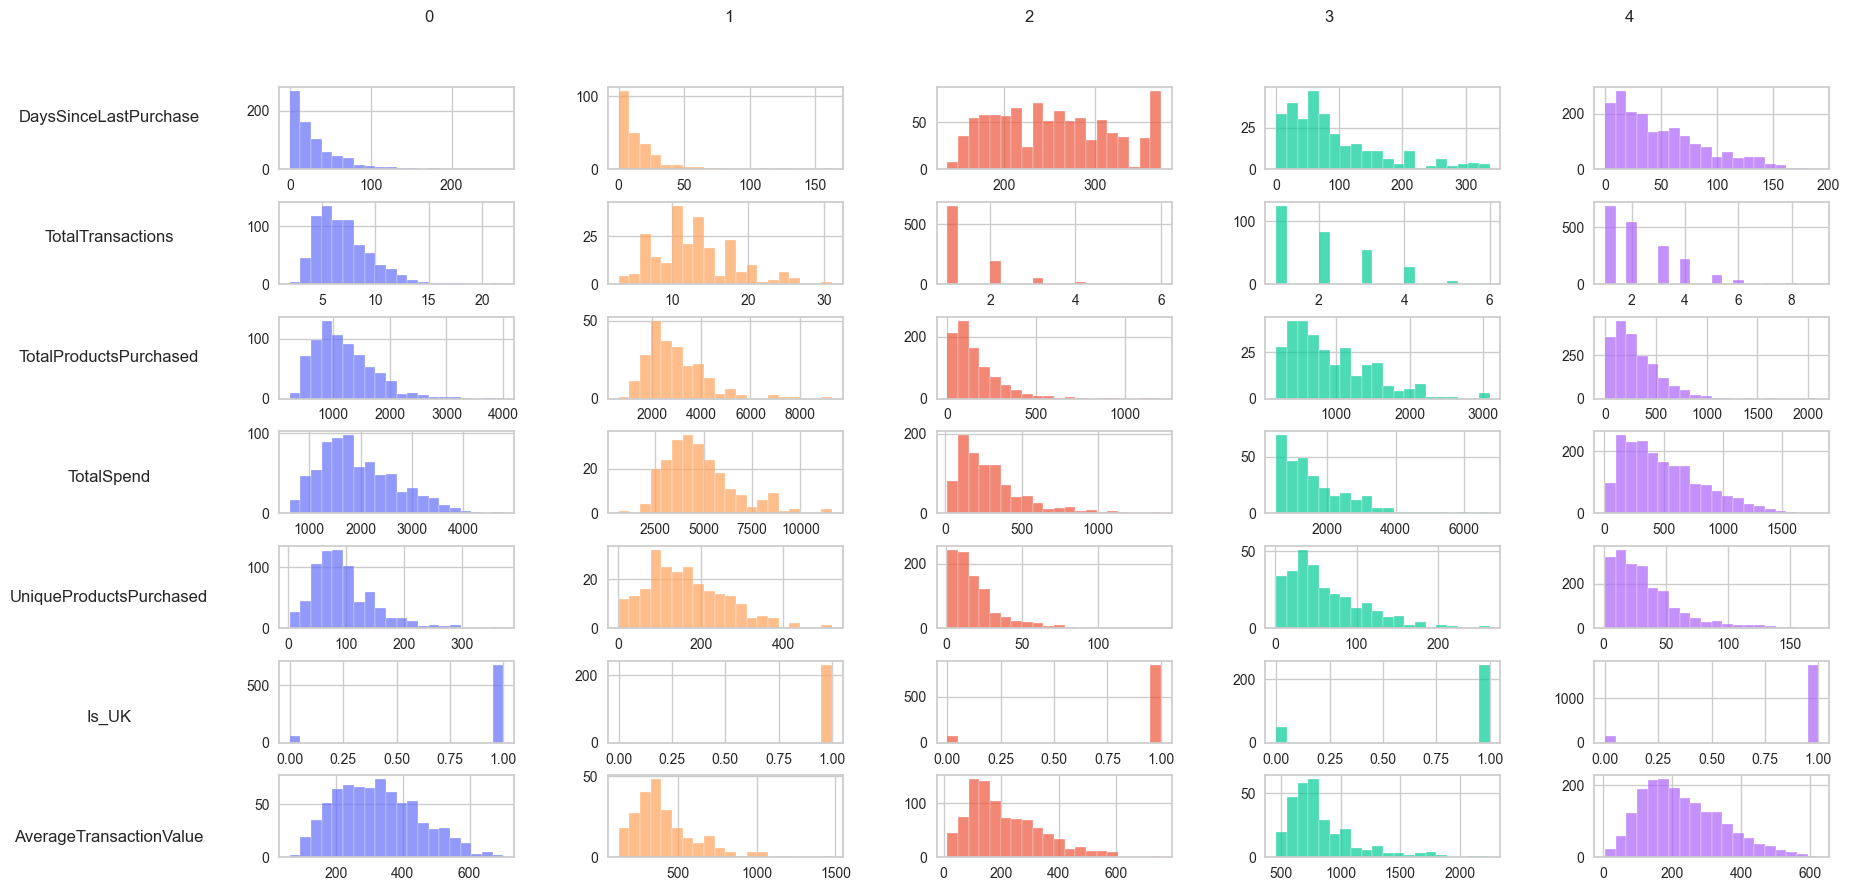

In [88]:
features = clean_customer_data.columns[1:-1]
clusters = sorted(clean_customer_data['cluster'].unique())
fig, ax = plt.subplots(len(features), len(clusters), figsize=(20, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = clean_customer_data[clean_customer_data['cluster'] == cluster][feature]
        ax[i, j].hist(data, bins=20, color=clusterColours[j], edgecolor='w', alpha=0.7)

for i in range(features.size):
    fig.text(0.04, 0.85 - i * 0.12, f'{features[i]}', ha='center', va='center', fontsize=12)

for i in range(len(clusters)):
    fig.text(0.2 + i * 0.15, 0.95,  f'{clusters[i]}', ha='center', va='center', fontsize=12)


# **Recomendations**
Personalised recommendation to suggest top product within a cluster they they the customer has not yet purchased.

In [89]:
# Choose from transaction data to include customers from cleaned customer data. 
transactionsData = df[df['CustomerID'].isin(clean_customer_data['CustomerID'])]
transactionsData = transactionsData.merge(clean_customer_data[['CustomerID', 'cluster']], on='CustomerID', how='left')
# Find best selling products in each cluster based on quantities sold
bestSellingProducts = transactionsData.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
bestSellingProducts = bestSellingProducts.sort_values(by=['cluster', 'Quantity'], ascending=False)
customerPurchases = transactionsData.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

In [90]:
recommendations = []
for cluster in bestSellingProducts['cluster'].unique():
    topProductsWithinCluster = bestSellingProducts[bestSellingProducts['cluster'] == cluster]
    customersInCluster = clean_customer_data[clean_customer_data['cluster'] == cluster]['CustomerID']
    for customer in customersInCluster:
        purchasedProducts = customerPurchases[(customerPurchases['CustomerID'] == customer) & (customerPurchases['cluster'] == cluster)]['StockCode'].tolist()
        topProductNotPurchased = topProductsWithinCluster[~topProductsWithinCluster['StockCode'].isin(purchasedProducts)].head(1)
        recommendations.append([customer, cluster] + topProductNotPurchased[['StockCode','Description']].values.flatten().tolist())

rec_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'StockCode', 'Description'])
rec_df.to_csv('./data/customer_recommendations.csv', index=False)
rec_df

,CustomerID,cluster,StockCode,Description
0,12358.0,4,84879,ASSORTED COLOUR BIRD ORNAMENT
1,12363.0,4,84879,ASSORTED COLOUR BIRD ORNAMENT
2,12367.0,4,84879,ASSORTED COLOUR BIRD ORNAMENT
3,12372.0,4,84879,ASSORTED COLOUR BIRD ORNAMENT
4,12374.0,4,84879,ASSORTED COLOUR BIRD ORNAMENT
...,...,...,...,...
4093,18245.0,0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
4094,18257.0,0,84879,ASSORTED COLOUR BIRD ORNAMENT
4095,18260.0,0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
4096,18272.0,0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
